In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import splitfolders

In [2]:
SOURCE_DIR = r"C:\Users\LENOVO\Desktop\IIS_Project\Foods"
OUTPUT_DIR = r"C:\Users\LENOVO\Desktop\IIS_Project\Splited_DataSet"

TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
VAL_DIR   = os.path.join(OUTPUT_DIR, "val")
TEST_DIR  = os.path.join(OUTPUT_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
if not (os.path.exists(TRAIN_DIR) and os.path.exists(VAL_DIR) and os.path.exists(TEST_DIR)):
    splitfolders.ratio(
        SOURCE_DIR,
        output=OUTPUT_DIR,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15)
    )
    print("\nDataset split saved to:", OUTPUT_DIR)
else:
    print("\nSplit folders already exist. Skipping split.")
    print("Split location:", OUTPUT_DIR)


Dataset split saved to: C:\Users\LENOVO\Desktop\IIS_Project\Splited_DataSet


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
)

Found 2329 files belonging to 5 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
)

Found 498 files belonging to 5 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

Found 504 files belonging to 5 classes.


In [7]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Chapathi', 'Dhal', 'Idli', 'Jelebi', 'Samosa']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

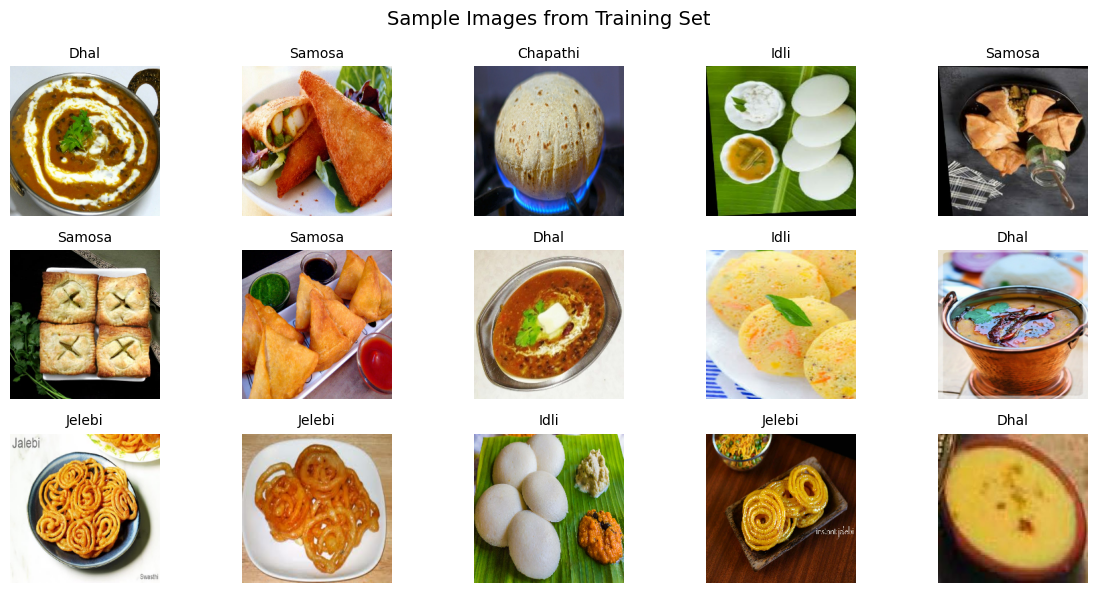

In [9]:
plt.figure(figsize=(12, 6))
images, labels = next(iter(train_ds))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])], fontsize=10)
    plt.axis("off")
plt.suptitle("Sample Images from Training Set", fontsize=14)
plt.tight_layout()
plt.show()


Class Distribution Table:
Class		Train	Val	Test	Total
Chapathi		546	117	118	781
Dhal		513	109	111	733
Idli		489	105	106	700
Jelebi		440	94	95	629
Samosa		341	73	74	488


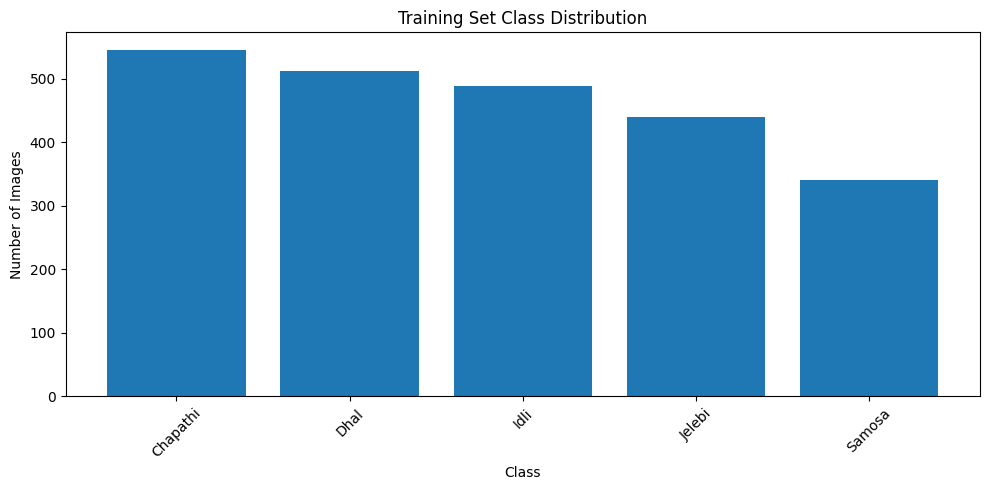

In [10]:
def count_images(folder, class_names):
    counts = []
    for cls in class_names:
        cls_path = os.path.join(folder, cls)
        n = 0
        if os.path.exists(cls_path):
            for f in os.listdir(cls_path):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    n += 1
        counts.append(n)
    return counts

train_counts = count_images(TRAIN_DIR, class_names)
val_counts   = count_images(VAL_DIR, class_names)
test_counts  = count_images(TEST_DIR, class_names)

print("\nClass Distribution Table:")
print("Class\t\tTrain\tVal\tTest\tTotal")
for i, cls in enumerate(class_names):
    total = train_counts[i] + val_counts[i] + test_counts[i]
    print(f"{cls}\t\t{train_counts[i]}\t{val_counts[i]}\t{test_counts[i]}\t{total}")

plt.figure(figsize=(10,5))
plt.bar(class_names, train_counts)
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
raw_img = images[0].numpy()
print("\nBefore normalization:")
print(f"Min: {raw_img.min()}, Max: {raw_img.max()}")

norm_img = raw_img / 255.0
print("\nAfter normalization:")
print(f"Min: {norm_img.min():.2f}, Max: {norm_img.max():.2f}")


Before normalization:
Min: 0.0, Max: 255.0

After normalization:
Min: 0.00, Max: 1.00


In [13]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(16, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
], name="Food_Image_Classification")

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "Food_Image_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,562,149 (21.22 MB)

 Trainable params: 5,562,149 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.4659 - loss: 1.2080 - val_accuracy: 0.6185 - val_loss: 0.9718
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.6544 - loss: 0.8799 - val_accuracy: 0.5984 - val_loss: 0.9147
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.7591 - loss: 0.6611 - val_accuracy: 0.7410 - val_loss: 0.6887
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.8334 - loss: 0.4577 - val_accuracy: 0.7349 - val_loss: 0.7095
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.8828 - loss: 0.3178 - val_accuracy: 0.7530 - val_loss: 0.7351
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - accuracy: 0.9279 - loss: 0.2212 - val_accuracy: 0.7751 - val_loss: 0.7206
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.9575 - loss: 0.1354 - val_accuracy: 0.7811 - val_loss: 0.8414
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.9592 - loss: 0.1247 - val_accu

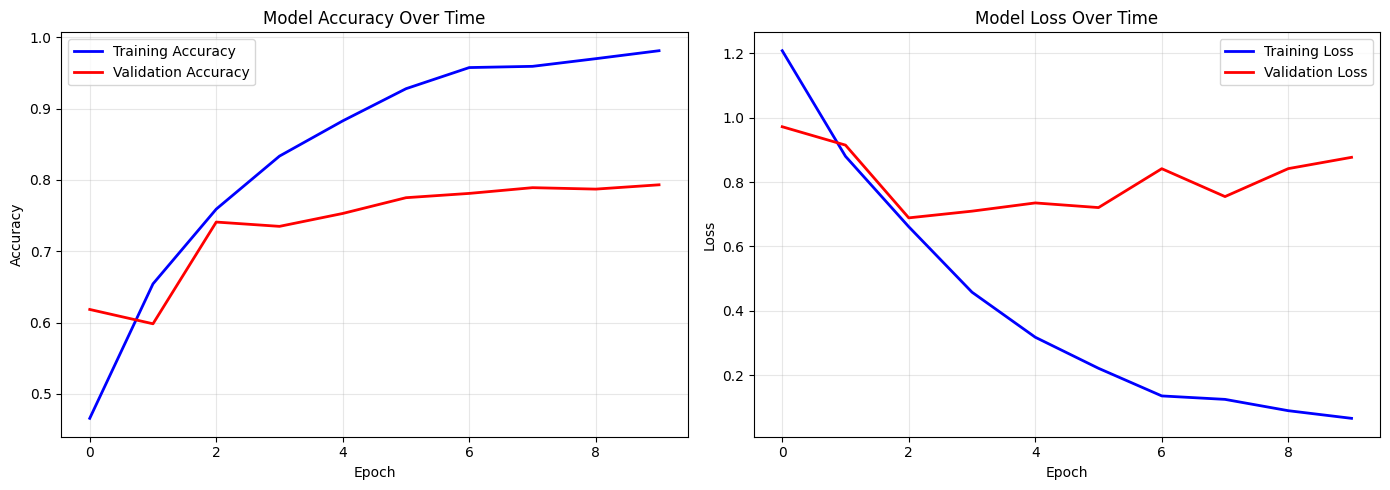

In [15]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="blue", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="red", linewidth=2)
plt.title("Model Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="blue", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", color="red", linewidth=2)
plt.title("Model Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 81.75%
Test Loss: 0.9891



Classification Report:
              precision    recall  f1-score   support

    Chapathi      0.845     0.924     0.883       118
        Dhal      0.821     0.784     0.802       111
        Idli      0.876     0.868     0.872       106
      Jelebi      0.766     0.863     0.812        95
      Samosa      0.737     0.568     0.641        74

    accuracy                          0.817       504
   macro avg      0.809     0.801     0.802       504
weighted avg      0.816     0.817     0.814       504



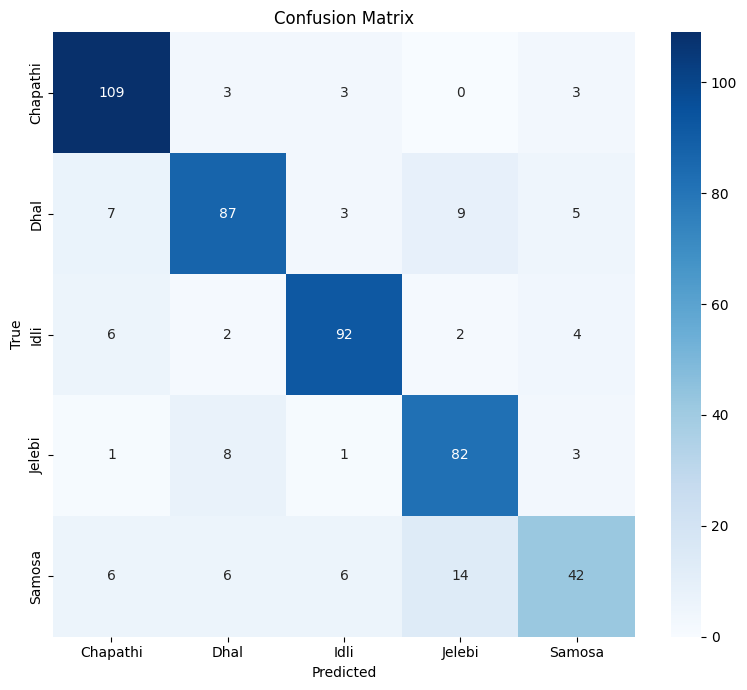

In [17]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

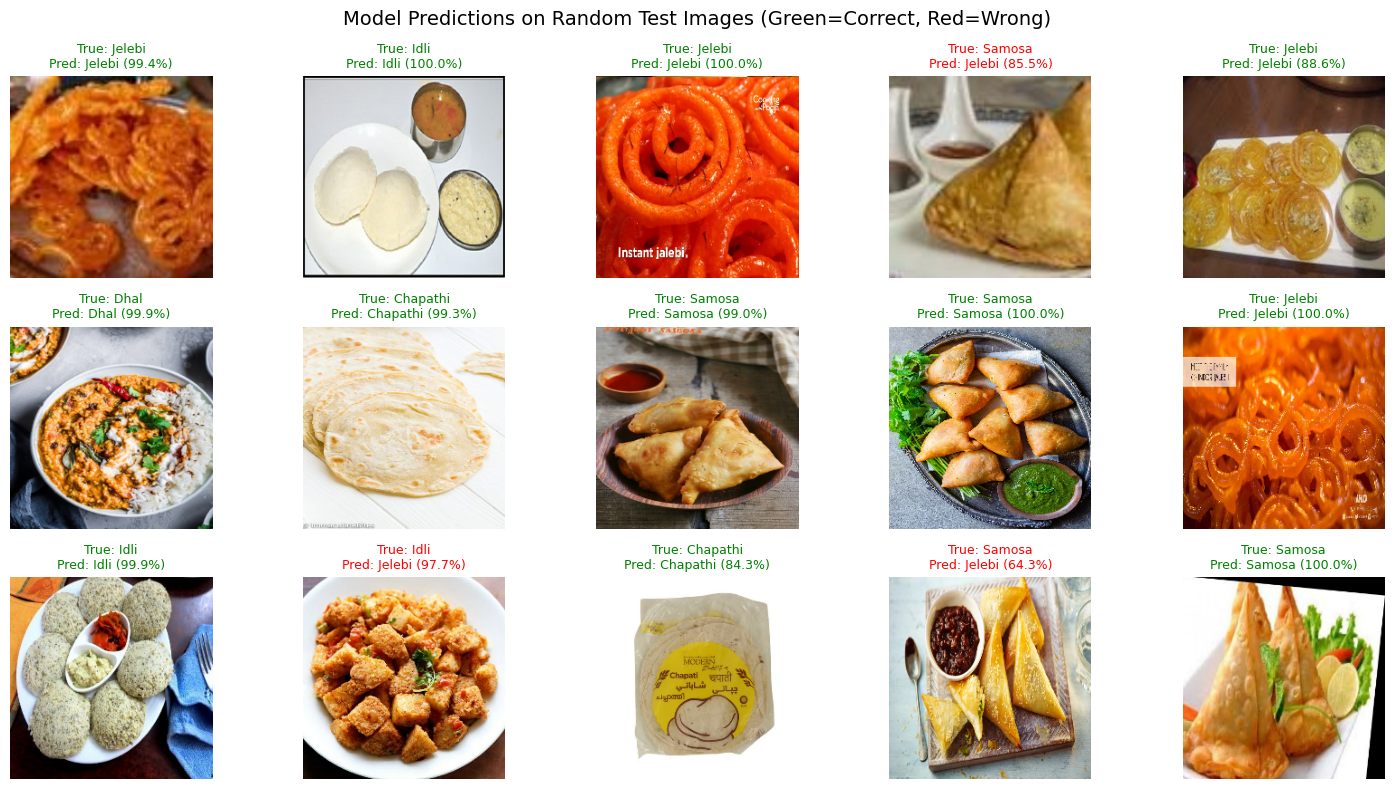

In [18]:
all_test_images = []
all_test_labels = []

for imgs, labs in test_ds:
    all_test_images.append(imgs.numpy())
    all_test_labels.append(labs.numpy())

all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

plt.figure(figsize=(15, 8))
num_images = 15
random_indices = np.random.choice(len(all_test_images), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)

    img = all_test_images[idx]
    true_idx = int(all_test_labels[idx])

    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    pred_idx = int(np.argmax(pred))
    conf = pred[pred_idx] * 100

    color = "green" if pred_idx == true_idx else "red"

    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]} ({conf:.1f}%)",
              fontsize=9, color=color)
    plt.axis("off")

plt.suptitle("Model Predictions on Random Test Images (Green=Correct, Red=Wrong)", fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
save_path = os.path.join(os.getcwd(), "Food_Classifier.h5")
model.save(save_path)

print("\nModel successfully saved!")
print("Save location:", save_path)


Model successfully saved!
Save location: C:\Users\LENOVO\Desktop\IIS_Project\Food_Classifier.h5


Initial Observations :-
1.The model achieved around 81% test accuracy, which shows that the basic CNN can classify most of the food images correctly.
2.The training accuracy is higher than the validation accuracy. This shows a small amount of overfitting.
3.The training loss keeps decreasing, but the validation loss increases slightly in later epochs. This means the model is starting to memorize some training data.
4.The overall F1-score is around 0.81, which shows balanced but improvable. 
5.Some mistakes may happen because some food images look similar and backgrounds are different.